Use CMap on the LINC1000 data set to rank drugs and other perturbations based on their similarity to the transcriptomic signature of Alzheimer's disease.

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.formula.api as smf
from matplotlib_venn import venn2, venn3
import re
import attila_utils

## Input gene sets

We see that only one gene, [SNCA](https://www.genecards.org/cgi-bin/carddisp.pl?gene=SNCA), is shared between the knowledge based AD gene set and the downregulated genes.  No gene is shared between the "knowledge genes" and the "up genes".

The venn diagram shows that the up and down gene sets share a missing "NA" value.

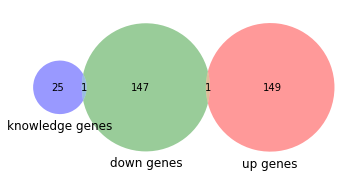

In [2]:
def read_genes(fpath='../../resources/CMap/sudhir-varma/up.genes.txt'):
    with open(fpath) as f:
        l = f.read().splitlines()
        val = set(l)
        return(val)

up_genes = read_genes('../../resources/CMap/sudhir-varma/up.genes.txt')
down_genes = read_genes('../../resources/CMap/sudhir-varma/down.genes.txt')
knowledge_genes = read_genes('../../results/2021-07-01-high-conf-ADgenes/AD-genes-knowledge')

fig, ax = plt.subplots()
venn3([up_genes, down_genes, knowledge_genes], ['up genes', 'down genes', 'knowledge genes'], ax=ax)

In [3]:
knowledge_genes.intersection(down_genes)

{'SNCA'}

In [4]:
up_genes.intersection(down_genes)

{'NA'}

## Analysis with Sudhir's results
### Sudhir's CMap LINCS1000 results

In [5]:
fpath = '../../resources/CMap/sudhir-varma/LINCS1000.results.xlsx'
#fpath = '../../results/2021-10-04-CMap-discussion/from-sudhir/LINCS1000.results.xlsx'
sudhir = pd.read_excel(fpath, 'lincs1000.result')
sudhir

,id,Perturbation type,Perturbation type detail,name,description,target,belongs_to,PC3,VCAP,A375,A549,HA1E,HCC515,HT29,MCF7,HEPG2,summary
0,CGS001-2617,KD,Gene-knockdown,GARS,"Aminoacyl tRNA synthetases / Class II, glycyl-...",NaN,Aminoacyl tRNA synthetases class II LOF,-99.66,NaN,-99.94,NaN,-94.59,NaN,46.19,-98.52,-26.25,-99.89
1,CGS001-55657,KD,Gene-knockdown,ZNF692,"Zinc fingers, C2H2-type, zinc finger protein 692",NaN,NaN,-67.11,32.48,-99.66,-50.60,0.00,-99.97,-82.15,NaN,-99.82,-99.89
2,CGS001-9638,KD,Gene-knockdown,FEZ1,fasciculation and elongation protein zeta 1 (z...,NaN,NaN,47.54,79.43,-89.22,-98.91,-98.48,-80.29,NaN,69.55,-99.88,-99.87
3,CGS001-132,KD,Gene-knockdown,ADK,"Adenosine turnover, adenosine kinase",NaN,NaN,-99.87,49.49,-89.48,50.10,-75.77,NaN,-81.86,-98.51,-99.62,-99.76
4,CGS001-79796,KD,Gene-knockdown,ALG9,Dolichyl D-mannosyl phosphate dependent mannos...,NaN,NaN,0.00,NaN,-99.85,-99.45,0.00,NaN,0.00,78.66,-98.27,-99.71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8964,CGS001-22827,KD,Gene-knockdown,PUF60,"RNA binding motif (RRM) containing, poly-U bin...",NaN,NaN,0.00,50.14,35.01,99.26,94.10,95.13,98.90,98.86,98.57,99.66
8965,CGS001-10247,KD,Gene-knockdown,HRSP12,heat-responsive protein 12,NaN,NaN,72.96,NaN,98.66,NaN,96.02,-80.00,87.67,98.40,99.29,99.74
8966,CGS001-55746,KD,Gene-knockdown,NUP133,nucleoporin 133kDa,NaN,"Minor histocompatibility antigens LOF, Nucleop...",NaN,45.23,98.71,99.03,99.28,83.13,97.27,99.07,98.75,99.76
8967,CGS001-2101,KD,Gene-knockdown,ESRRA,"Estrogen-related receptors, estrogen-related r...",NaN,NaN,87.47,0.00,99.49,99.79,99.98,NaN,0.00,96.69,96.97,99.84


Load results of v1 of the network proximity based DrugBank screen:

In [6]:
fpath = '../../results/2021-09-28-drugbank-screen-v1/knowledge-approved-sorted-extended.csv'
dbscreen = pd.read_csv(fpath, index_col='name')
#dbscreen = pd.read_csv(fpath, index_col='drugbank_id')
dbscreen.head()

,drugbank_id,rank,groups,symbol,hgnc_id,d,avg_d_H0,sdev_d_H0,z,p,symbols,n_targets,agora_genes,sum_agora_nomin,avg_agora_nomin,sum_sq_agora_nomin,avg_sq_agora_nomin
name,,,,,,,,,,,,,,,,,
Chlorpheniramine,DB01114,1,approved,HRH1|SLC6A4|SLC6A2|SLC6A3,HGNC:5182|HGNC:11050|HGNC:11048|HGNC:11049,1.000000,1.963500,0.167460,-5.753623,4.367536e-09,"{'SLC6A3', 'HRH1', 'SLC6A4', 'SLC6A2'}",4,set(),0,0.0,0,0.0
Venlafaxine,DB00285,2,approved,SLC6A4|SLC6A2|SLC6A3,HGNC:11050|HGNC:11048|HGNC:11049,1.000000,1.957000,0.183291,-5.221217,8.887556e-08,"{'SLC6A3', 'SLC6A4', 'SLC6A2'}",3,set(),0,0.0,0,0.0
Nomifensine,DB04821,3,approved|withdrawn,SLC6A2|SLC6A3|MAOB|MAOA|MPO|SLC6A4|SLC18A2,HGNC:11048|HGNC:11049|HGNC:6834|HGNC:6833|HGNC...,1.285714,1.998143,0.138566,-5.141426,1.363308e-07,"{'SLC6A4', 'SLC18A2', 'MAOB', 'MAOA', 'MPO', '...",7,set(),0,0.0,0,0.0
Duloxetine,DB00476,4,approved,SLC6A4|SLC6A2|SLC6A3,HGNC:11050|HGNC:11048|HGNC:11049,1.000000,1.954000,0.187070,-5.099701,1.700955e-07,"{'SLC6A3', 'SLC6A4', 'SLC6A2'}",3,set(),0,0.0,0,0.0
Desvenlafaxine,DB06700,5,approved|investigational,SLC6A2|SLC6A4|SLC6A3,HGNC:11048|HGNC:11050|HGNC:11049,1.000000,1.951000,0.187792,-5.064126,2.051396e-07,"{'SLC6A3', 'SLC6A4', 'SLC6A2'}",3,set(),0,0.0,0,0.0


About half of the perturbations have two or more replicates in the LINCS1000 CMap results

['named-figure/sudhir-perturbations-replicates.png',
 'named-figure/sudhir-perturbations-replicates.pdf']

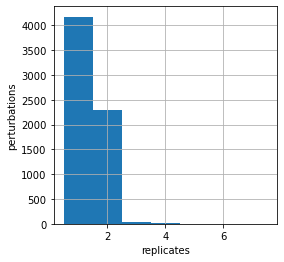

In [7]:
sudhir['name1'] = sudhir.name.str.title()
sudhir_avg = sudhir.groupby('name1').mean()
fig, ax = plt.subplots(figsize=(4, 4))
vc = sudhir['name1'].value_counts()
vc.hist(ax=ax, bins=np.arange(0.5, vc.max() + 1))
ax.set_ylabel('perturbations')
ax.set_xlabel('replicates')
attila_utils.savefig(fig, 'sudhir-perturbations-replicates')

Get approved drugs shared by `dbscreen` and `lincs` 

In [8]:
common_drugs = list(set(dbscreen.index).intersection(set(sudhir_avg.index)))
common_drugs.sort()
'{} of {} approved DrugBank drugs are in LINCS1000'.format(len(common_drugs), len(dbscreen))

'625 of 1605 approved DrugBank drugs are in LINCS1000'

['named-figure/sudhir-hist-summary.png',
 'named-figure/sudhir-hist-summary.pdf']

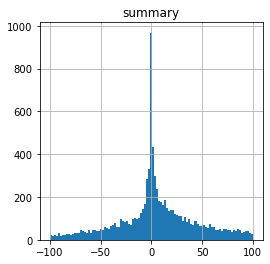

In [9]:
fig, ax = plt.subplots(figsize=(4, 4))
sudhir.hist(column='summary', ax=ax, bins=101)
attila_utils.savefig(fig, 'sudhir-hist-summary')

### Regressing LINCS summary score on network based rank

This chunk of analysis leads to an unexpected result: drugs that rank high in the network based DrugBank screen rank low in the CMap/LINCS analysis.

In [10]:
sel_cols = ['drugbank_id', 'groups', 'symbol', 'rank', 'z', 'p']
dbscreen['name1'] = dbscreen.index
dbscreen_sudhir = pd.merge(dbscreen[sel_cols + ['name1']], sudhir, on='name1', how='inner')
dbscreen_sudhir.to_csv('../../results/2021-10-04-CMap-discussion/dbscreen-lincs_sudhir.csv')

['named-figure/sudhir-lincs-rank.png', 'named-figure/sudhir-lincs-rank.pdf']

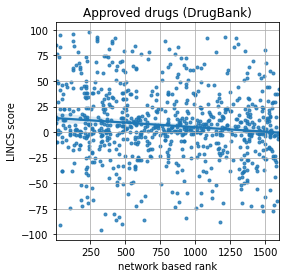

In [11]:
def plot_ols_dbscreen_lincs(merged=dbscreen_sudhir, x='rank', y='summary'):
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    g = sns.regplot(x=x, y=y, data=merged, fit_reg=True, ax=ax, marker='.')
    ax.set_xlabel('network based rank')
    ax.set_ylabel('LINCS score')
    ax.grid(True)
    ax.set_title('Approved drugs (DrugBank)')
    return((fig, ax))

fig, ax = plot_ols_dbscreen_lincs(dbscreen_sudhir)
attila_utils.savefig(fig, 'sudhir-lincs-rank')

In [12]:
def fit_ols_dbscreen_lincs(merged=dbscreen_sudhir, x='rank', y='summary'):
    ols_fit = smf.ols(y + ' ~ ' + x, data=merged).fit()
    val = pd.DataFrame({'beta hat': ols_fit.params[x], 'beta stderr': np.sqrt(ols_fit.cov_params().loc[x, x]), 'pvalue': ols_fit.pvalues[x]}, index=['fit results'])
    return(val)

fit_ols_dbscreen_lincs(dbscreen_sudhir)

,beta hat,beta stderr,pvalue
fit results,-0.008918,0.00261,0.000664


### Regressing network based rank on LINCS summary score

Here we swap the response and the single explanatory variable.

['named-figure/sudhir-rank-lincs.png', 'named-figure/sudhir-rank-lincs.pdf']

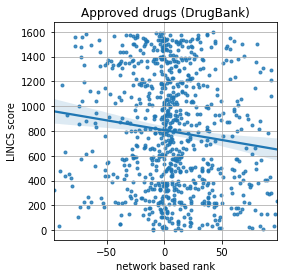

In [13]:
fig, ax = plot_ols_dbscreen_lincs(dbscreen_sudhir, x='summary', y='rank')
attila_utils.savefig(fig, 'sudhir-rank-lincs')

The scale of $\beta$ is different but the $p$ value is the same as

In [14]:
fit_ols_dbscreen_lincs(dbscreen_sudhir, x='summary', y='rank')

,beta hat,beta stderr,pvalue
fit results,-1.589697,0.465193,0.000664


### Regressing average LINCS summary score on network based rank

Here we average the LINCS summary score over all replicates for each drug.  Thus we lose data points.

In [15]:
dbscreen_sudhir_avg = pd.concat([dbscreen[sel_cols], sudhir_avg], axis=1, join='inner')
dbscreen_sudhir_avg.to_csv('../../results/2021-10-04-CMap-discussion/dbscreen-lincs_sudhir_avg.csv')

['named-figure/sudhir-avglincs-rank.png',
 'named-figure/sudhir-avglincs-rank.pdf']

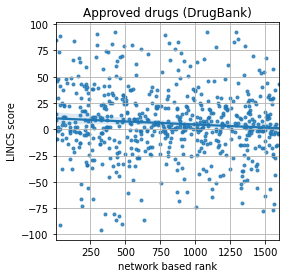

In [16]:
fig, ax = plot_ols_dbscreen_lincs(dbscreen_sudhir_avg)
attila_utils.savefig(fig, 'sudhir-avglincs-rank')

In [17]:
fit_ols_dbscreen_lincs(merged=dbscreen_sudhir_avg)

,beta hat,beta stderr,pvalue
fit results,-0.005852,0.002795,0.036702


## Analysis with my LINCS results
### My LINCS query

We use the [query tool](https://clue.io/query) of the CMap portal [clue.io](https://clue.io).  The input data are up and down regulated genes in AD compiled by Sudhir Varma using multiple GEO datasets and an R script calculating a FDR adjusted p value for each gene's differential expression test.  The number of genes in each set corresponds to the upper size limit of gene sets for CMap.

In [18]:
%%bash
cd ~/CTNS/resources/CMap/sudhir-varma/
echo "$(wc -l up.genes.txt) up regulated genes, including:"
head -n3 up.genes.txt
echo "$(wc -l down.genes.txt) up regulated genes, including:"
head -n3 down.genes.txt

     150 up.genes.txt up regulated genes, including:
NACC2
SNRNP48
FOXF1
     149 down.genes.txt up regulated genes, including:
GALNT17
SCG5
MRPL14


### My LINCS results

After inspection of the tarball downloaded from [here](https://s3.amazonaws.com/data.clue.io/api/attila.jones@nih.gov/results/Oct_04_2021/my_analysis.sig_queryl1k_tool.615b71e7e8d3bc0017eb9248/my_analysis.sig_queryl1k_tool.615b71e7e8d3bc0017eb9248.tar.gz)

In [19]:
%%bash
cd ../../results/2021-10-04-CMap-discussion/
ls

dbscreen-clue__lincs.csv
dbscreen-lincs__lincs.csv
dbscreen-lincs_sudhir.csv
dbscreen-lincs_sudhir_avg.csv
my_analysis.sig_queryl1k_tool.615b71e7e8d3bc0017eb9248
my_analysis.sig_queryl1k_tool.615b71e7e8d3bc0017eb9248.tar.gz
query-1


Note that `query-1` is just a symlink to `my_analysis.sig_queryl1k_tool.615b71e7e8d3bc0017eb9248`

In [20]:
%%bash
cd ../../results/2021-10-04-CMap-discussion/
ls query-1

arfs
down.gmt
gsea
matrices
ncs.gct
query_config.yaml
up.gmt


### arfs

In [21]:
%%bash
cd ../../results/2021-10-04-CMap-discussion/
ls -R query-1/arfs/

TAG
index.txt

query-1/arfs//TAG:
query_result.gct


In [22]:
fpath = '../../results/2021-10-04-CMap-discussion/query-1/arfs/TAG/query_result.gct'
clue = pd.read_csv(fpath, sep='\t', skiprows=[0, 1, 3], na_values='-666')#.drop('1', axis=1)
clue

/usr/local/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (5,16,17) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,id,pert_id,pert_iname,cell_iname,pert_type,pert_idose,pert_itime,nsample,ss_ngene,cc_q75,...,qc_pass,is_hiq,is_ncs_sig,is_exemplar_sig,is_null_sig,moa,target_name,raw_cs,fdr_q_nlog10,norm_cs
0,KDB008_HEPG2_96H:TRCN0000050256:-666,TRCN0000050256,BPHL,HEPG2,trt_sh,NaN,96 h,4,214,0.55,...,1,0.0,1,1,0,NaN,NaN,0.5032,3.4284,1.9937
1,KDC006_PC3_96H:TRCN0000059426:-666,TRCN0000059426,ALB,PC3,trt_sh,NaN,96 h,2,171,0.54,...,1,0.0,1,1,0,NaN,NaN,0.4922,2.8711,1.9501
2,KDB006_HT29_96H:TRCN0000007624:-666,TRCN0000007624,BTG2,HT29,trt_sh,NaN,96 h,4,219,0.53,...,1,0.0,1,1,0,NaN,NaN,0.4817,2.6436,1.9086
3,PAC021_U2OS_6H:BRD-K55311609-001-01-3:10.1092,BRD-K55311609,BRD-K55311609,U2OS,trt_cp,10 uM,6 h,3,55,0.15,...,1,0.0,1,1,0,NaN,NaN,0.4769,2.5694,1.8897
4,KDB009_A549_96H:TRCN0000029342:-666,TRCN0000029342,CORO1A,A549,trt_sh,NaN,96 h,3,155,0.55,...,1,0.0,1,1,0,NaN,NaN,0.4762,2.5593,1.8868
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423417,KDD003_VCAP_120H:TRCN0000007363:-666,TRCN0000007363,USP9X,VCAP,trt_sh,NaN,120 h,3,131,0.38,...,1,0.0,1,1,0,NaN,NaN,-0.4565,15.6536,-1.8270
423418,KDC004_PC3_96H:TRCN0000010079:-666,TRCN0000010079,ADK,PC3,trt_sh,NaN,96 h,3,56,0.46,...,1,0.0,1,1,0,NaN,NaN,-0.4589,15.6536,-1.8369
423419,KDD007_MCF7_96H:TRCN0000016723:-666,TRCN0000016723,ZNF426,MCF7,trt_sh,NaN,96 h,3,189,0.61,...,1,0.0,1,1,0,NaN,NaN,-0.4597,15.6536,-1.8398
423420,KDB002_HEPG2_96H:TRCN0000234705:-666,TRCN0000234705,HIGD2A,HEPG2,trt_sh,NaN,96 h,3,132,0.34,...,1,0.0,1,1,0,NaN,NaN,-0.4651,15.6536,-1.8616


Some perturbations are replicated several hundred times while many only once.

Manual inspection reveals that the replicates correspond to:
* multiple (many) cell types/lines
* multiple doses
* multiple exposure times

In [23]:
sel_cols1 = ['pert_iname', 'cell_iname', 'pert_type', 'pert_idose', 'pert_itime', 'nsample', 'raw_cs', 'fdr_q_nlog10', 'norm_cs']
df = clue.loc[clue['pert_iname'] == 'afatinib', sel_cols1]
df.sort_values(['cell_iname'])

,pert_iname,cell_iname,pert_type,pert_idose,pert_itime,nsample,raw_cs,fdr_q_nlog10,norm_cs
137549,afatinib,A375,trt_cp,0.04 uM,24 h,2,0.1825,0.0173,0.7233
95457,afatinib,A375,trt_cp,2.22 uM,24 h,2,0.2285,0.2012,0.9053
180350,afatinib,A549,trt_cp,10 uM,24 h,2,0.0000,-0.0000,0.0000
195787,afatinib,A549,trt_cp,2.22 uM,24 h,2,0.0000,-0.0000,0.0000
7421,afatinib,ASC,trt_cp,10 uM,24 h,4,0.3326,1.5342,1.3178
144138,afatinib,BJAB,trt_cp,10 uM,4 h,3,0.0000,-0.0000,0.0000
180364,afatinib,BT20,trt_cp,1.11 uM,24 h,2,0.0000,-0.0000,0.0000
37692,afatinib,HA1E,trt_cp,2.22 uM,24 h,2,0.2776,0.7655,1.0998
116689,afatinib,HA1E,trt_cp,10 uM,24 h,3,0.2108,0.1007,0.8353
144148,afatinib,HBL1,trt_cp,2.5 uM,24 h,3,0.0000,-0.0000,0.0000


['named-figure/clue-perturbations-replicates.png',
 'named-figure/clue-perturbations-replicates.pdf']

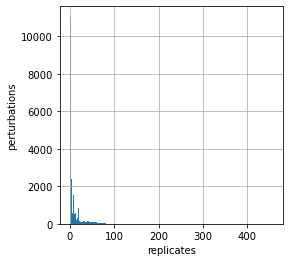

In [24]:
fig, ax = plt.subplots(figsize=(4, 4))
clue['name1'] = clue.pert_iname.str.title()
vc = clue['name1'].value_counts()
vc.hist(ax=ax, bins=np.arange(0.5, vc.max() + 1))
ax.set_ylabel('perturbations')
ax.set_xlabel('replicates')
attila_utils.savefig(fig, 'clue-perturbations-replicates')

### Regression analysis

We see that, unlike the `summary` score variable in Sudhir's results, the `norm_cs` and `raw_cs` variables in my results are strongly trimodal.

['named-figure/clue-hist-norm_cs.png', 'named-figure/clue-hist-norm_cs.pdf']

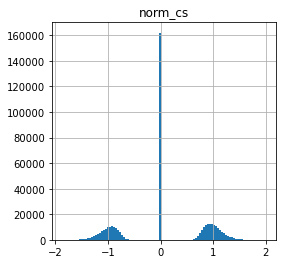

In [25]:
fig, ax = plt.subplots(figsize=(4, 4))
clue.hist(column='norm_cs', ax=ax, bins=101, density=False)
attila_utils.savefig(fig, 'clue-hist-norm_cs')

['named-figure/clue-hist-raw_cs.png', 'named-figure/clue-hist-raw_cs.pdf']

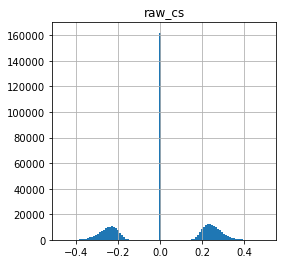

In [26]:
fig, ax = plt.subplots(figsize=(4, 4))
clue.hist(column='raw_cs', ax=ax, bins=101, density=False)
attila_utils.savefig(fig, 'clue-hist-raw_cs')

In [27]:
dbscreen_clue = pd.merge(dbscreen[sel_cols + ['name1']], clue, on='name1', how='inner')
dbscreen_clue.to_csv('../../results/2021-10-04-CMap-discussion/dbscreen-clue__lincs.csv')

### Inference based on t-test

In [28]:
clue_groups = ['low LINCS score', 'high LINCS score']
ranks_a = dbscreen_clue.loc[dbscreen_clue.norm_cs < 0, 'rank']
ranks_b = dbscreen_clue.loc[dbscreen_clue.norm_cs > 0, 'rank']
stats.ttest_ind(ranks_a, ranks_b)

Ttest_indResult(statistic=3.983039531091436, pvalue=6.853157178245572e-05)

['named-figure/clue-rank-boxplot.png', 'named-figure/clue-rank-boxplot.pdf']

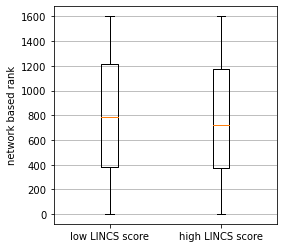

In [29]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.boxplot([ranks_a, ranks_b])
ax.set_xticklabels(clue_groups)
ax.grid(True, axis='y')
ax.set_ylabel('network based rank')
attila_utils.savefig(fig, 'clue-rank-boxplot')

['named-figure/clue-rank-barplot.png', 'named-figure/clue-rank-barplot.pdf']

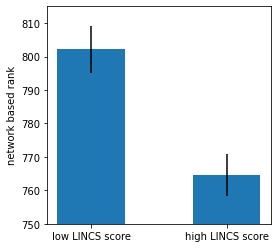

In [30]:
ranks_avg = [np.mean(y) for y in [ranks_a, ranks_b]]
ranks_sem = [np.std(y) / np.sqrt(len(y)) for y in [ranks_a, ranks_b]]
fig, ax = plt.subplots(figsize=(4, 4))
ax.bar(x=[0, 1], height=ranks_avg, yerr=ranks_sem, width=0.5)
ax.set_xticks([0, 1])
ax.set_xticklabels(clue_groups)
ax.set_ylabel('network based rank')
ax.set_ylim([750, 815])
attila_utils.savefig(fig, 'clue-rank-barplot')

This section confirms the anticorrelation we previously saw between the networ based analysis and CMap/LINCS.

### Inference based on linear model

Even though the fit looks ugly, the inference on $\beta$ gives even stronger result than the t-test.

['named-figure/clue-rank.png', 'named-figure/clue-rank.pdf']

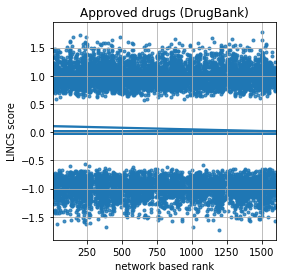

In [31]:
fig, ax = plot_ols_dbscreen_lincs(dbscreen_clue, x='rank', y='norm_cs')
attila_utils.savefig(fig, 'clue-rank')

In [32]:
fit_ols_dbscreen_lincs(dbscreen_clue, x='rank', y='norm_cs')

,beta hat,beta stderr,pvalue
fit results,-0.000058,0.000014,0.000024


Again, the anticorrelation between the networ based analysis and CMap/LINCS is confirmed.

The above results are stronger than the t-test due to the data points with $\text{norm_cs} = 0$.  Removing these points gives a less significant result than the previous linear model fit.  However, the result is still slightly more significant than the t-test, indicating that including the exact value of $\text{norm_cs}$ contains information on network based rank in addition to the indicator variable $\mathbf{1}_{\text{norm_cs} < 0}$.

In [33]:
fit_ols_dbscreen_lincs(dbscreen_clue.loc[dbscreen_clue.norm_cs != 0], x='rank', y='norm_cs')

,beta hat,beta stderr,pvalue
fit results,-0.00009,0.000022,0.000044


### Conclusion

Even though the fit looks ugly, the inference on $\beta$, the effect of network based rank on LINCS score is qualitatively the same as for Sudhir's LINCS results.

## L1000CDS^2

There is an [alternative CMap/LINCS resource](https://maayanlab.cloud/l1000cds2/#/index) developed by the Ma'ayanlab.  It only outputs the top 50 perturbations that are either reversing or mimicking the input differential expression (DE) signature.  I queried this resource using the same input DE signature (the same up and down gene sets) as for the clue resource.

In [34]:
def read_l1000cds(fpath = '../../resources/CMap/L1000CDS2/drugs-reversing-signature.csv'):
    l1000cds_revers = pd.read_csv(fpath).drop('Rank', axis=1)
    l1000cds_revers['pert_id'] = l1000cds_revers['Signature URL'].apply(lambda s: re.sub('^.*(BRD-.+):.*$', '\\1', s))
    return(l1000cds_revers)

l1000cds_mimic = read_l1000cds(fpath = '../../resources/CMap/L1000CDS2/drugs-mimicking-signature.csv')
l1000cds_revers = read_l1000cds(fpath = '../../resources/CMap/L1000CDS2/drugs-reversing-signature.csv')
l1000cds_revers['score'] = - l1000cds_revers['score']
l1000cds = pd.concat([l1000cds_revers, l1000cds_mimic], axis=0)
l1000cds['name1'] = l1000cds.Perturbation.str.title()

In [35]:
l1000cds

,score,Perturbation,Perturbation LIFE URL,Perturbation PubChem URL,Perturbation DrugBank URL,Cell-line,Dose,Time,Signature URL,pert_id,name1
0,-0.0443,HLI 373,http://life.ccs.miami.edu/life/summary?mode=Sm...,http://pubchem.ncbi.nlm.nih.gov/summary/summar...,None,CL34,10.0um,6.0h,https://maayanlab.cloud/l1000cds2/meta?sig_id=...,BRD-K17349619,Hli 373
1,-0.0443,vorinostat,http://life.ccs.miami.edu/life/summary?mode=Sm...,http://pubchem.ncbi.nlm.nih.gov/summary/summar...,http://www.drugbank.ca/drugs/DB02546,HT115,10.0um,6.0h,https://maayanlab.cloud/l1000cds2/meta?sig_id=...,BRD-K81418486,Vorinostat
2,-0.0394,Rottlerin,http://life.ccs.miami.edu/life/summary?mode=Sm...,http://pubchem.ncbi.nlm.nih.gov/summary/summar...,None,HCC515,10.0um,24.0h,https://maayanlab.cloud/l1000cds2/meta?sig_id=...,BRD-K03816923,Rottlerin
3,-0.0394,trichostatin A,http://life.ccs.miami.edu/life/summary?mode=Sm...,http://pubchem.ncbi.nlm.nih.gov/summary/summar...,None,A549,10.0um,6.0h,https://maayanlab.cloud/l1000cds2/meta?sig_id=...,BRD-A19037878,Trichostatin A
4,-0.0394,BRD-K25737009,http://life.ccs.miami.edu/life/summary?mode=Sm...,http://pubchem.ncbi.nlm.nih.gov/summary/summar...,None,HCC515,40.0um,24.0h,https://maayanlab.cloud/l1000cds2/meta?sig_id=...,BRD-K25737009,Brd-K25737009
...,...,...,...,...,...,...,...,...,...,...,...
45,0.0394,AMSACRINE,http://life.ccs.miami.edu/life/summary?mode=Sm...,http://pubchem.ncbi.nlm.nih.gov/summary/summar...,None,HA1E,10.0um,24.0h,https://maayanlab.cloud/l1000cds2/meta?sig_id=...,BRD-K98490050,Amsacrine
46,0.0394,AMSACRINE,http://life.ccs.miami.edu/life/summary?mode=Sm...,http://pubchem.ncbi.nlm.nih.gov/summary/summar...,None,HCC515,10.0um,24.0h,https://maayanlab.cloud/l1000cds2/meta?sig_id=...,BRD-K98490050,Amsacrine
47,0.0394,PERIPLOCYMARIN,http://life.ccs.miami.edu/life/summary?mode=Sm...,http://pubchem.ncbi.nlm.nih.gov/summary/summar...,None,A375,10.0um,24.0h,https://maayanlab.cloud/l1000cds2/meta?sig_id=...,BRD-A45333398,Periplocymarin
48,0.0394,Etoposide,http://life.ccs.miami.edu/life/summary?mode=Sm...,http://pubchem.ncbi.nlm.nih.gov/summary/summar...,None,A375,10.0um,6.0h,https://maayanlab.cloud/l1000cds2/meta?sig_id=...,BRD-A18419789,Etoposide


Again, we confirm the anticorrelation between the network based rank and CMap/LINCS rank.

['named-figure/clue-rank.png', 'named-figure/clue-rank.pdf']

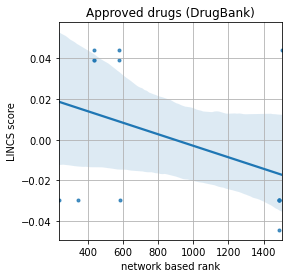

In [36]:
dbscreen_l1000cds = pd.merge(dbscreen[sel_cols + ['name1']], l1000cds, on='name1', how='inner')
fig, ax = plot_ols_dbscreen_lincs(dbscreen_l1000cds, x='rank', y='score')
attila_utils.savefig(fig, 'clue-rank')

## Consistency among three CMap results

We see that the three CMap/LINCS data sets are fairly consistent with each other.

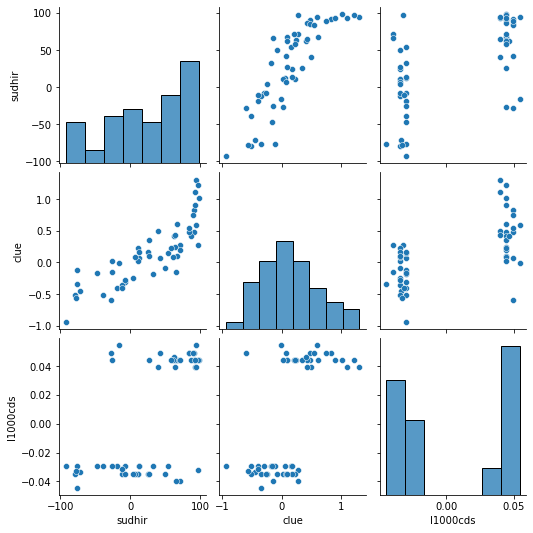

In [37]:
clue_avgscore = clue.groupby('pert_id').mean()['norm_cs'].to_frame('clue')
l1000cds_avgscore = l1000cds.groupby('pert_id').mean()['score'].to_frame('l1000cds')
sudhir_avgscore = sudhir.groupby('id').mean()['summary'].to_frame('sudhir')
avgscore = pd.concat([sudhir_avgscore, clue_avgscore, l1000cds_avgscore], axis=1, join='inner')
#avgscore.plot(kind='scatter', x='clue', y='l1000cds')
sns.pairplot(avgscore)

## Odds and ends
### gsea

In [38]:
%%bash
cd ../../results/2021-10-04-CMap-discussion/
ls -R query-1/gsea/

TAG

query-1/gsea//TAG:
arfs
config.yaml
matrices
success.txt

query-1/gsea//TAG/arfs:
NORM_CS
index.txt

query-1/gsea//TAG/arfs/NORM_CS:
gsea_result.gct

query-1/gsea//TAG/matrices:
cs.gctx
dn.gmt
fdr_qvalue.gctx
nes.gctx
up.gmt


In [39]:
fpath = '../../results/2021-10-04-CMap-discussion/query-1/gsea/TAG/arfs/NORM_CS/gsea_result.gct'
df = pd.read_csv(fpath, sep='\t', skiprows=[0, 1, 3], na_values='-666')
df

,id,set_type,set_size,src_set_size,num_hiq_sig,pct_hiq_sig,num_uniq_pert,pct_src_pert,src_set_id,cell_iname,pert_type,is_filtered_set,desc,raw_cs,fdr_q_nlog10,norm_cs
0,MTOR_INHIBITOR:TRT_CP,MOA_CLASS,706,37,403,57.082153,30,81.081081,MTOR_INHIBITOR,NaN,TRT_CP,True,MTOR_INHIBITOR:trt_cp,0.6278,15.6536,2.8336
1,CP_MTOR_INHIBITOR:TRT_CP,PCL,528,16,312,59.090909,16,100.000000,CP_MTOR_INHIBITOR,NaN,TRT_CP,True,CP_MTOR_INHIBITOR:trt_cp,0.6388,3.1563,2.8169
2,CP_PI3K_INHIBITOR:TRT_CP,PCL,465,16,268,57.634409,16,100.000000,CP_PI3K_INHIBITOR,NaN,TRT_CP,True,CP_PI3K_INHIBITOR:trt_cp,0.5731,1.8693,2.5111
3,MTOR_INHIBITOR:PC3:TRT_CP,MOA_CLASS,38,37,28,73.684211,26,70.270270,MTOR_INHIBITOR,PC3,TRT_CP,True,MTOR_INHIBITOR:PC3:trt_cp,0.7512,1.8196,2.4720
4,MTOR_INHIBITOR:HA1E:TRT_CP,MOA_CLASS,37,37,27,72.972973,26,70.270270,MTOR_INHIBITOR,HA1E,TRT_CP,True,MTOR_INHIBITOR:HA1E:trt_cp,0.7021,1.6591,2.3104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12095,BIOCARTA_P53HYPOXIA_PATHWAY:A549:TRT_OE,PATHWAY_SET,117,23,38,32.478632,14,60.869565,BIOCARTA_P53HYPOXIA_PATHWAY,A549,TRT_OE,True,BIOCARTA_P53HYPOXIA_PATHWAY:A549:trt_oe,-0.5477,1.4231,-2.1864
12096,ST_GA12_PATHWAY:HEPG2:TRT_SH.CGS,PATHWAY_SET,10,23,8,80.000000,10,43.478261,ST_GA12_PATHWAY,HEPG2,TRT_SH.CGS,True,ST_GA12_PATHWAY:HEPG2:trt_sh.cgs,-0.9369,1.4703,-2.2094
12097,CP_HDAC_INHIBITOR:TRT_CP,PCL,333,20,179,53.753754,18,90.000000,CP_HDAC_INHIBITOR,NaN,TRT_CP,True,CP_HDAC_INHIBITOR:trt_cp,-0.4931,1.4703,-2.2183
12098,KEGG_RENAL_CELL_CARCINOMA:U2OS:TRT_OE,PATHWAY_SET,39,70,13,33.333333,25,35.714286,KEGG_RENAL_CELL_CARCINOMA,U2OS,TRT_OE,True,KEGG_RENAL_CELL_CARCINOMA:U2OS:trt_oe,-0.6676,1.8717,-2.2814


### Converting BRD ID to DrugBank ID

The conversion might be difficult.  See [this](https://think-lab.github.io/d/51/) and [this](https://www.biostars.org/p/249949/) threads on old forums.

The following sheet downloaded from the [LINCS Data Portal | Small Molecules](http://lincsportal.ccs.miami.edu/SmallMolecules/catalog) might be useful for the conversion.

In [40]:
pd.read_csv('../../resources/CMap/SmallMolecule_1633383104307.csv').head()

,SM_Name,SM_LINCS_ID,SM_Alternative_Name,SM_PubChem_CID,SM_SMILES_Parent,SM_SMILES_Batch,SM_InChi_Parent,SM_Molecular_Mass,MOLECULAR_FORMULA,SM_ChEBI_ID
0,Pyridoxine,LSM-5324,"Lyphomed,Hexa-Betalin,Pyridoxine HCl,PYRID-20,...",1054.0,Cc1ncc(CO)c(CO)c1O,NaN,InChI=1S/C8H11NO3/c1-5-8(12)7(4-11)6(3-10)2-9-...,169.18,C8H11NO3,"16709, 30961"
1,Vigabatrin,LSM-4959,"CPP-109,Gamma-Vinyl GABA,MDL-71754,RMI-71754,S...",5665.0,NC(CCC(=O)O)C=C,NaN,"InChI=1S/C6H11NO2/c1-2-5(7)3-4-6(8)9/h2,5H,1,3...",129.16,C6H11NO2,63638
2,AC1N8GBV,LSM-16274,"2-Furaldehyde (4-amino-5-methyl-4H-1\,2\,4-tri...",4343351.0,Cc1nnc(NN=Cc2occc2)n1N,NaN,InChI=1S/C8H10N6O/c1-6-11-13-8(14(6)9)12-10-5-...,206.20,C8H10N6O,104911
3,Formononetin,LSM-19000,"Formononetin,NSC-93360",5280378.0,COc1ccc(cc1)C2=COc3cc(O)ccc3C2=O,NaN,InChI=1S/C16H12O4/c1-19-12-5-2-10(3-6-12)14-9-...,268.26,C16H12O4,18088
4,9-Cyclopentyl-6-mercaptopurine,LSM-24332,9-Cyclopentyl-6-mercaptopurine 19487,3034494.0,Sc1ncnc2c1ncn2C3CCCC3,NaN,InChI=1S/C10H12N4S/c15-10-8-9(11-5-12-10)14(6-...,220.29,C10H12N4S,112922


In [41]:
%connect_info

{
  "shell_port": 58951,
  "iopub_port": 58952,
  "stdin_port": 58953,
  "control_port": 58955,
  "hb_port": 58954,
  "ip": "127.0.0.1",
  "key": "a830f18f-f1a73936c0a4d065f1167a1d",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-75be5dc7-c87b-4ab9-9c32-fc81c4ac95cb.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
